#               Finding the optimal table arrangement at a wedding

In this project I am showcasing two techniques for finding an optimal seating arrangement at a wedding. By optimal, I mean that the people around each table know or like each other (depending on the metric we use) maximally. The project was inspired by Bellows and Peterson [[1]](https://www.improbable.com/news/2012/Optimal-seating-chart.pdf "Optimal seating chart"). The first technique I use is simply an implementation of the model in [1]. The second technique I use is spectral clustering [[3]](http://snap.stanford.edu/class/cs224w-readings/ng01spectralcluster.pdf "Spectral clustering"). The models are ran on two different examples, both small.


### Table of Contents

* [0 Preparations](#prep)
* [1 Method 1: Zero-one linear programming](#method1)
    * [1.1 Example 1: A toy example with zero-one linear programming](#example_1_1)
    * [1.2 Example 2: An imaginary Game of Thrones wedding with zero-one linear programming](#example_1_2)
* [2 Method 2: Spectral clustering](#method2)
    * [2.1 Example 1: A toy example with spectral clustering](#example_2_1)
    * [2.2 Example 2: An imaginary Game of Thrones wedding with pectral clustering](#example_2_2)
* [3 Summary](#summary)

### 0 Preparations <a class="anchor" id="prep"></a>

In [1]:
import numpy as np
import pandas as pd
import networkx as nx # network analytics
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import spectral_clustering # spectral clustering
import gurobipy as grb # optimization 
# Note: if you want to run this on your own computer, you need to install gurobi and have an active license.
# If you have a Mac with Anaconda, look at: https://www.gurobi.com/gurobi-and-anaconda-for-mac/

### 1 Zero-one linear programming<a class="anchor" id="method1"></a>
First we implement the model from [1]. Let's assume that we have $m$ guests whom we have to seat at $n$ tables, each of which can seat $a$ people at most. As an input we use a connection matrix, in which cells indicate how closely a pair of invitees are related. We can use any metric to measure relatedness, such as the number of common friends or a subjective evaluation of how well the pair of invitees get along. Then, we can formulate a mathematical model to maximize the guests' relatedness at each table. The variables that go into this model are the following:

| Variable             | Description                                                  |
|----------------------|--------------------------------------------------------------|
| $m$                  | total number of guests                                       |
| $n$                  | total number of tables                                       |
| $a$                  | maximum number of guests each table can seat                 |
| $b$                  | minimum number of people each guest must know at their table |
| $C^{jk}$             | connection matrix of guests                                  |
| $i$                  | table identifier (from 1 to $n$)                             |
| $j,k$                | guest identifier (from 1 to $m$)                             |
| $g_i^j$              | 1 if guest $j$ sits at table $i$, 0 otherwise                |
| $g_i^k$              | 1 if guest $k$ sits at table $i$, 0 otherwise                |
| $p_i^{jk}=g_i^j g_i^k$ | 1 if guests $j$ and $k$ sit at table $i$, 0 otherwise        |

The optimization problem can be written as follows:


\begin{array}{l}
\max _{g_{i}^{j}  g_{i}^{k}} & \sum_{i=1}^{n} \sum_{j=1}^{m-1} \sum_{k=j+1}^{m} C^{j k} p_{i}^{j k} \quad &(1)\\
\text { subject to: } \quad & \sum_{i=1}^{n} g_{i}^{j}=1, \quad \forall j \quad &(2) \\
\quad \quad \quad \quad \quad & \sum_{j=1}^{m} g_{i}^{j} \leq a, \quad \forall i \quad &(3)\\
\quad \quad \quad \quad \quad & \sum_{j=1}^{m} p_{i}^{jk} \geq(b+1) g_{i}^{k}, \quad \forall i, k, C^{jk}>0 \quad &(4)\\
\quad \quad \quad \quad \quad & \sum_{j=1}^{m} p_{i}^{jk} \leq a g_{i}^{k}, \quad \forall i, k \quad &(5)\\
\quad \quad \quad \quad \quad & \sum_{k=1}^{m} p_{i}^{jk} \leq a g_{i}^{j}, \quad \forall i, j \quad &(6)\\
\quad \quad \quad \quad \quad & g_{i}^{k}, g_{i}^{k}, p_{i}^{jk} \in\{0,1\} \quad &(7)
\end{array}


The objective (1) is to maximize the relatedness between invitees that sit at the same table. Constraints (2) and (3) ensure respectively that each guest is only seated at one table and that each table has at most $a$ guest assigned. Each guest must know at least $b$ other guests at their table, which is enforced by (4). (5) and (6) are created from (3) and are introduced to linearize the optimization problem. (7) specifies that the decision variables are binary, making this optimization problem a zero-one linear programming exercise.

### 1.1 Example 1: A toy example<a class="anchor" id="example_1_1"></a>
The first example is the one used in [1], making sure that I get the same results with a different optimization software.

In [2]:
# Defining the connection matrix found in the original paper
C_matrix=np.array([
[1,50,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
[50,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
[1,1,1,50,1,1,1,1,10,0,0,0,0,0,0,0,0],
[1,1,50,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
[1,1,1,1,1,50,1,1,1,0,0,0,0,0,0,0,0],
[1,1,1,1,50,1,1,1,1,0,0,0,0,0,0,0,0],
[1,1,1,1,1,1,1,50,1,0,0,0,0,0,0,0,0],
[1,1,1,1,1,1,50,1,1,0,0,0,0,0,0,0,0],
[1,1,10,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,1,50,1,1,1,1,1,1],
[0,0,0,0,0,0,0,0,0,50,1,1,1,1,1,1,1],
[0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
[0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
[0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
[0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
[0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
[0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1]])

In [3]:
# Let's check if the connection matrix is correct:
# It has to be a square matrix:
print(C_matrix.shape)
# And it has to be symmetric:
print(np.all(np.abs(C_matrix-C_matrix.T) < 1e-24))

(17, 17)
True


In [4]:
# Setting parameters
m = 17
n = 2
a = 10
b = 1
set_I = range(1, n+1)
set_J = range(1, m+1)
set_K = range(1, m+1)
C = {(j,k): C_matrix[(j-1),(k-1)] for j in set_J for k in set_K}

We will solve the optimization in Gurobi. We need to:
* define our decision variables. These are $g_i^j$ and $g_i^k$.
* add our constraints, that is we have to translate equations (2) to (6) into Gurobi constraints.
* define the objective function and the type of the problem (maximization or minimization).

[[3]](https://medium.com/opex-analytics/optimization-modeling-in-python-pulp-gurobi-and-cplex-83a62129807a) provides examples, through which the syntax for Gurobi can be learned.

In [5]:
opt_model = grb.Model(name="MIP Model")

Using license file /Users/matevaradi/gurobi.lic
Academic license - for non-commercial use only


In [6]:
# Setting decision variables
g_vars  = {(i,j):opt_model.addVar(vtype=grb.GRB.BINARY,
                        name="g_{0}_{1}".format(i,j)) 
for i in set_I for j in set_J}

In [7]:
# Adding constraints
# (2)
for j in set_J:
    opt_model.addConstr(lhs=grb.quicksum(g_vars[i,j] for i in set_I),
                       sense=grb.GRB.EQUAL,
                        rhs=1)
    
#(3)
for i in set_I:
    opt_model.addConstr(lhs=grb.quicksum(g_vars[i,j] for j in set_J),
                        sense=grb.GRB.LESS_EQUAL,
                        rhs=a)
    
# (4)
for i in set_I:
    for k in set_K:
        opt_model.addConstr(
            lhs=grb.quicksum(g_vars[i,k] * g_vars[i,j]*int(i!=j) for j in set_J),
            sense=grb.GRB.GREATER_EQUAL,
            rhs= (b+1)*g_vars[i,k]*int(i!=j))
            
# (5)
for i in set_I:
    for k in set_K:
        opt_model.addConstr(lhs=grb.quicksum(g_vars[i,j] * g_vars[i,k] for j in set_J),
                            sense=grb.GRB.LESS_EQUAL,
                            rhs=a*g_vars[i,k])

# (6)
for i in set_I:
    for j in set_J:       
        opt_model.addConstr(lhs=grb.quicksum(g_vars[i,j] * g_vars[i,k] for k in set_K),
                            sense=grb.GRB.LESS_EQUAL,
                            rhs= a*g_vars[i,j])

In [8]:
# Defining the objective (1)
objective = grb.quicksum(g_vars[i,j]*g_vars[i,k]*C[j,k]*int(i!=j) for i in set_I for j in set_J for k in set_K)

opt_model.ModelSense = grb.GRB.MAXIMIZE
opt_model.setObjective(objective)

In [9]:
# Running the optimization
opt_model.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 19 rows, 34 columns and 68 nonzeros
Model fingerprint: 0x5bc3ace2
Model has 160 quadratic objective terms
Model has 102 quadratic constraints
Variable types: 0 continuous, 34 integer (34 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 17 rows and 17 columns
Presolve time: 0.02s
Presolved: 2 rows, 17 columns, 34 nonzeros
Presolved model has 81 quadratic objective terms
Presolved model has 102 quadratic constraint(s)
Variable types: 0 continuous, 17 integer (17 binary)

Root relaxation: objective 5.950916e+02, 22 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

In [10]:
# Since we only have 2 tables, it is enough to look at one "table" or half of the binary decision variables
[g_vars.get((1,x)) for x in range(17)]

[None,
 <gurobi.Var g_1_1 (value 1.0)>,
 <gurobi.Var g_1_2 (value 1.0)>,
 <gurobi.Var g_1_3 (value 1.0)>,
 <gurobi.Var g_1_4 (value 1.0)>,
 <gurobi.Var g_1_5 (value 1.0)>,
 <gurobi.Var g_1_6 (value 1.0)>,
 <gurobi.Var g_1_7 (value 1.0)>,
 <gurobi.Var g_1_8 (value 1.0)>,
 <gurobi.Var g_1_9 (value 1.0)>,
 <gurobi.Var g_1_10 (value 0.0)>,
 <gurobi.Var g_1_11 (value 0.0)>,
 <gurobi.Var g_1_12 (value 0.0)>,
 <gurobi.Var g_1_13 (value 0.0)>,
 <gurobi.Var g_1_14 (value 0.0)>,
 <gurobi.Var g_1_15 (value 0.0)>,
 <gurobi.Var g_1_16 (value 0.0)>]

We can see that the first 9 guests are seated together at table number 1, while the other 7 guests sit at table number 2. Looking at the connection matrix, this is no surprise at all.

### 1.2 An imaginary Game of Thrones wedding with  zero-one linear programming <a class="anchor" id="example_1_2"></a>
Let's use Game of Thrones network data to look at another example.


In [11]:
# Load data
got_data=pd.read_csv("asoiaf-all-edges.csv") 
# downloaded from https://github.com/mathbeveridge/asoiaf/blob/master/data/asoiaf-all-edges.csv
got_data.head()

,Source,Target,Type,id,weight
0,Addam-Marbrand,Brynden-Tully,Undirected,0,3
1,Addam-Marbrand,Cersei-Lannister,Undirected,1,3
2,Addam-Marbrand,Gyles-Rosby,Undirected,2,3
3,Addam-Marbrand,Jaime-Lannister,Undirected,3,14
4,Addam-Marbrand,Jalabhar-Xho,Undirected,4,3


The data contains edges of the network of Game of Thrones (the book). Weights are calculated based on how frequently the *Source* character and the *Target* character appear on the same page. 

Let's focus on a small number of characters. For example let's imagine an alternative ending for Season 1, where Sansa Stark and Joffrey Baratheon get married and our task is to seat the Stark and Lannister families and the members of the Small Council. 

In [12]:
characters=["Jon-Snow","Arya-Stark","Sansa-Stark","Bran-Stark","Rickon-Stark","Catelyn-Stark",
            "Theon-Greyjoy","Robb-Stark","Eddard-Stark",
            "Tyrion-Lannister","Jaime-Lannister","Cersei-Lannister","Lancel-Lannister",
            "Tywin-Lannister","Kevan-Lannister","Joffrey-Baratheon","Tommen-Baratheon",'Robert-Baratheon',"Varys",
           "Gregor-Clegane",'Sandor-Clegane','Petyr-Baelish']
# Characters with ids:
character_id = {characters[i]:i for i in range(len(characters))} 

In [13]:
character_connections=got_data[(got_data["Source"].isin(characters) ) & (got_data["Target"].isin(characters) )]
# Only names and node weight is needed
character_connections=character_connections[["Source","Target","weight"]]
# Attaching character ids to dataframe
character_connections["Source_id"]=character_connections["Source"].apply(lambda x: character_id.get(x))
character_connections["Target_id"]=character_connections["Target"].apply(lambda x: character_id.get(x))
character_connections.head()

,Source,Target,weight,Source_id,Target_id
299,Arya-Stark,Bran-Stark,40,1,3
303,Arya-Stark,Catelyn-Stark,8,1,5
304,Arya-Stark,Cersei-Lannister,25,1,11
311,Arya-Stark,Eddard-Stark,46,1,8
315,Arya-Stark,Gregor-Clegane,10,1,19


We can create a graph visualization of the characters' connections with the networkx package. 

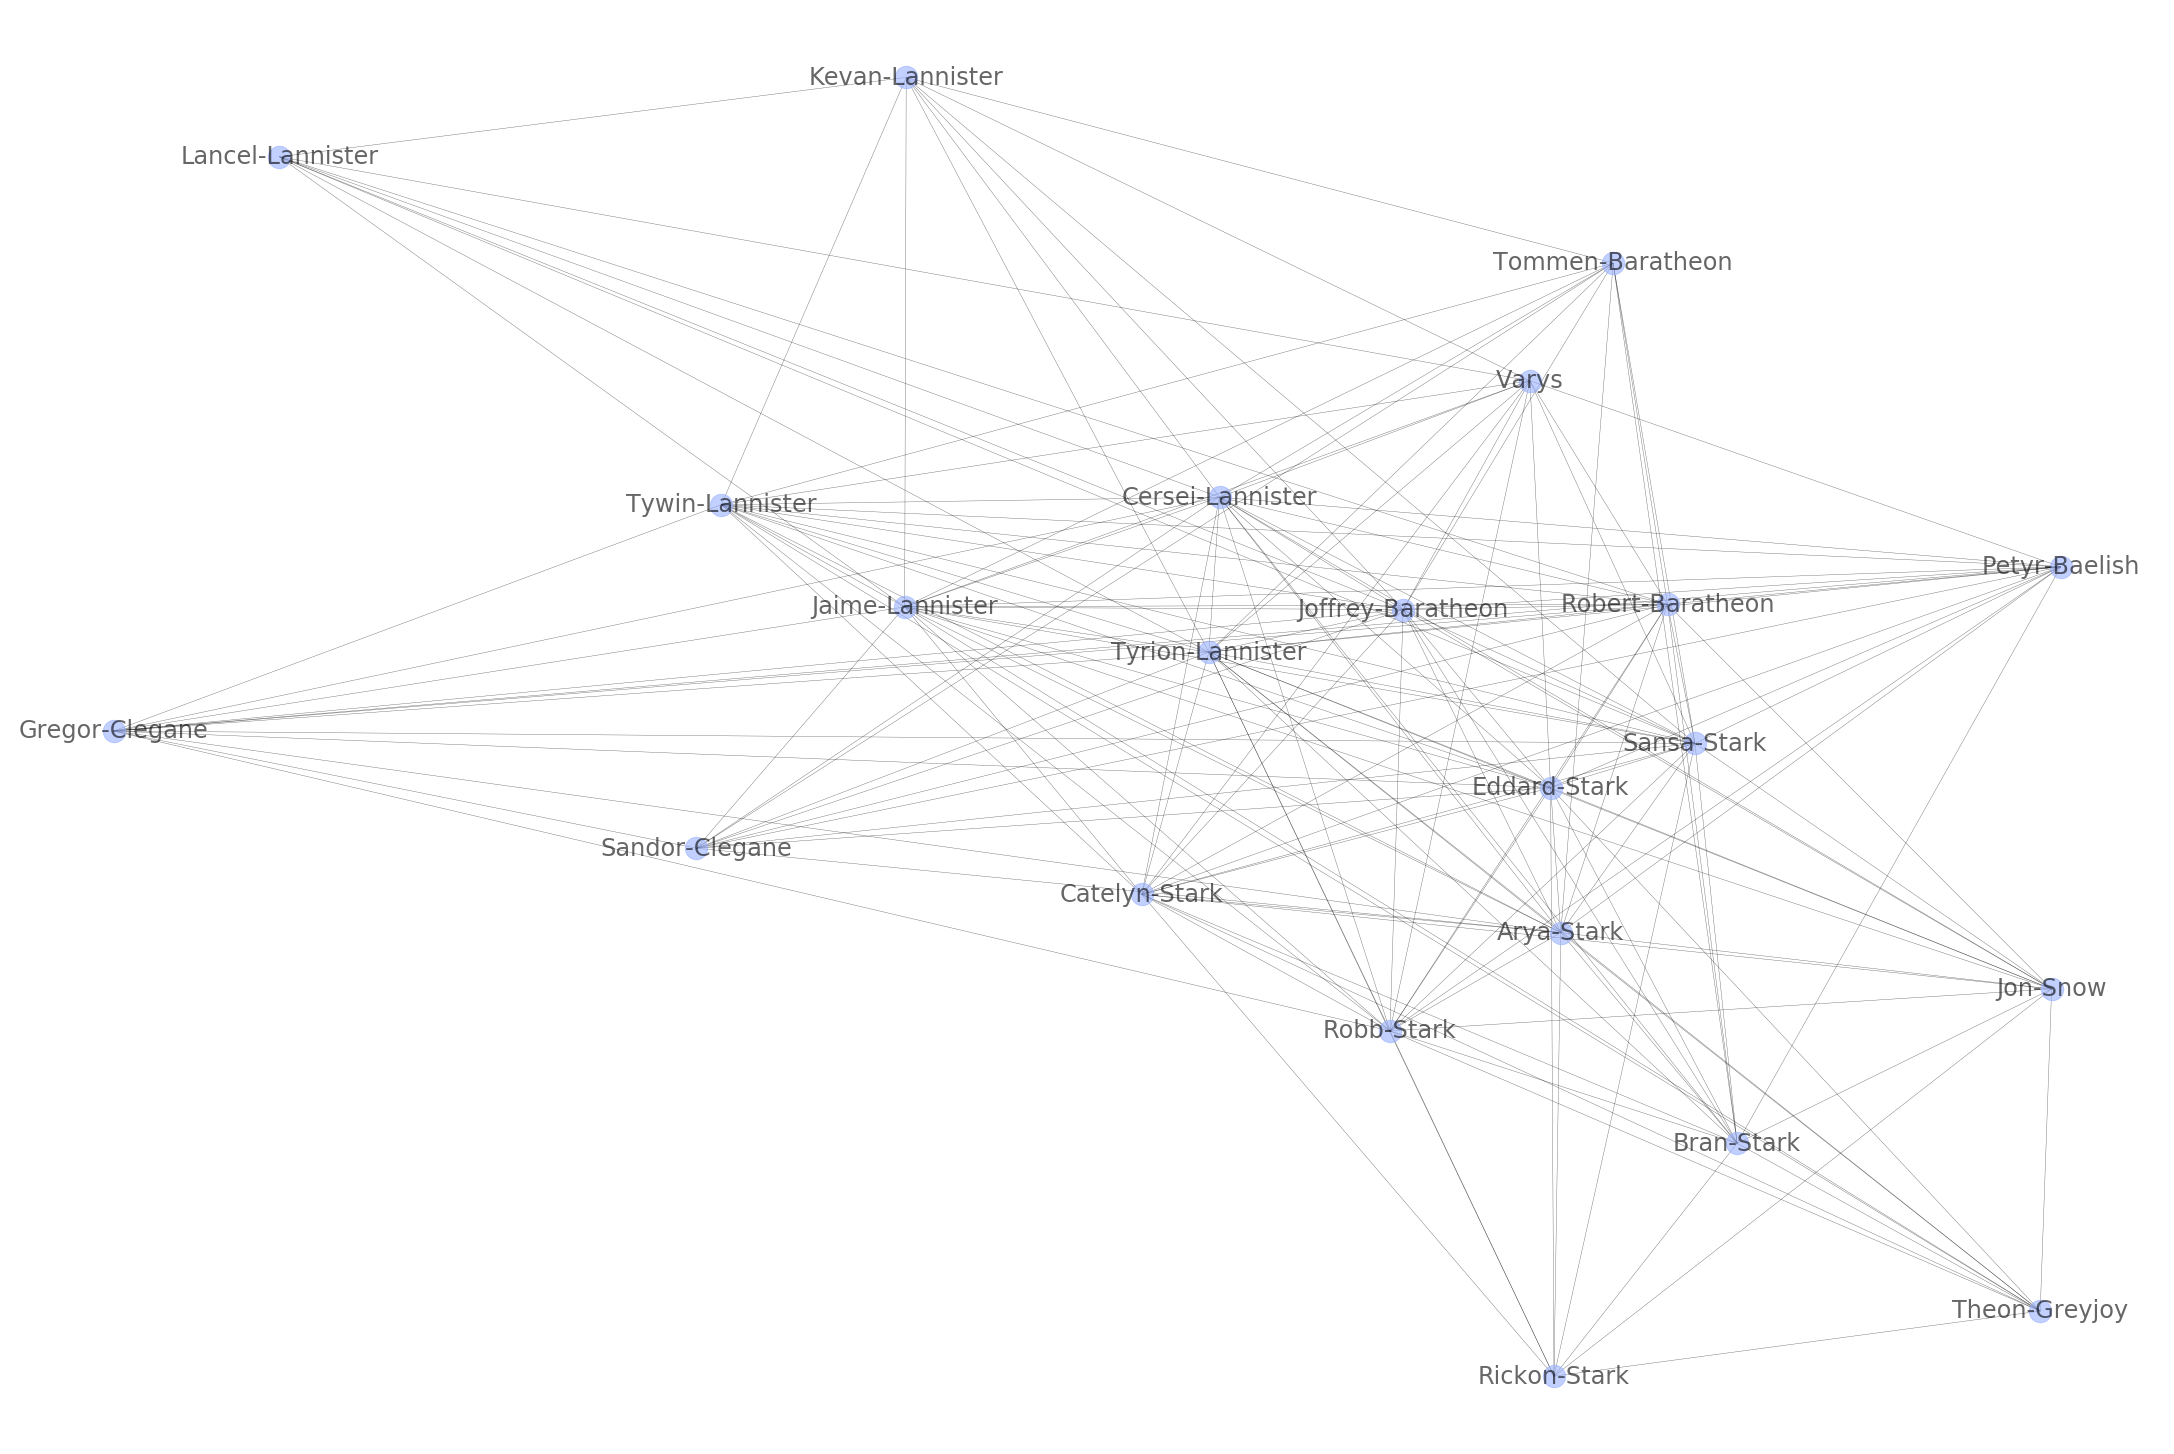

In [14]:
G = nx.Graph() #initialize graph structure
for index, row in character_connections.iterrows():
    G.add_edge(row['Source'],row['Target'],weight=row['weight']) #adding edges

# creating plot:
plt.figure(figsize=(30,20))
nx.draw(G,node_size=500,width=0.4,with_labels=True,alpha=0.6,font_size=24,\
       pos=nx.spring_layout(G,k=1.3,iterations=50),node_color="#99b1ff")

Let's run the optimization. First we have to load the connections data into a matrix format. Then we have to define the parameters of the model.This time we will try to seat our guests at four tables.

In [15]:
# Loading the got_data dataframe into a matrix of connections
C_matrix_got=np.zeros((len(characters),len(characters)))
for i in range(len(characters)):
    for j in range(len(characters)):
        if not character_connections[(character_connections["Source_id"]==i )& 
                                  (character_connections["Target_id"]==j)].empty:
            C_matrix_got[i,j]=character_connections[(character_connections["Source_id"]==i )& 
                                  (character_connections["Target_id"]==j)]["weight"]
# Finally we symmetrize the matrix, so that all weights are stored both in C_matrix[i,j] and C_matrix[j,i]
C_matrix_got=C_matrix_got + C_matrix_got.T - np.diag(C_matrix_got.diagonal())

In [16]:
# defining parameters
m = len(characters) # number of invitees to the wedding
n = 4   # tables
a = 6  # one table can seat 6 people
b = 1   # each character must know at least one other character
set_I = range(1, n+1)
set_J = range(1, m+1)
set_K = range(1, m+1)
C = {(j,k): C_matrix_got[(j-1),(k-1)] for j in set_J for k in set_K} # C_matrix_got elements stored in a dictionary

Now we can prepare and run the optimization. Everything is the same as in the first example.

In [17]:
opt_model = grb.Model(name="MIP Model")
# Setting decision variables
g_vars  = {(i,j):opt_model.addVar(vtype=grb.GRB.BINARY,
                        name="g_{0}_{1}".format(i,j)) 
for i in set_I for j in set_J}
# Adding constraints

# (2)
for j in set_J:
    opt_model.addConstr(lhs=grb.quicksum(g_vars[i,j] for i in set_I),
                       sense=grb.GRB.EQUAL,
                        rhs=1)
    
#(3)
for i in set_I:
    opt_model.addConstr(lhs=grb.quicksum(g_vars[i,j] for j in set_J),
                        sense=grb.GRB.LESS_EQUAL,
                        rhs=a)
    
# (4)
for i in set_I:
    for k in set_K:
        opt_model.addConstr(
            lhs=grb.quicksum(g_vars[i,k] * g_vars[i,j]*int(i!=j) for j in set_J),
            sense=grb.GRB.GREATER_EQUAL,
            rhs= (b+1)*g_vars[i,k]*int(i!=j))
            
# (5)
for i in set_I:
    for k in set_K:
        opt_model.addConstr(lhs=grb.quicksum(g_vars[i,j] * g_vars[i,k] for j in set_J),
                            sense=grb.GRB.LESS_EQUAL,
                            rhs=a*g_vars[i,k])

# (6)
for i in set_I:
    for j in set_J:       
        opt_model.addConstr(lhs=grb.quicksum(g_vars[i,j] * g_vars[i,k] for k in set_K),
                            sense=grb.GRB.LESS_EQUAL,
                            rhs= a*g_vars[i,j])
# Defining the objective
objective = grb.quicksum(g_vars[i,j]*g_vars[i,k]*C[j,k]*int(i!=j) for i in set_I for j in set_J for k in set_K)

opt_model.ModelSense = grb.GRB.MAXIMIZE
opt_model.setObjective(objective)

# Running the optimization
opt_model.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 26 rows, 88 columns and 176 nonzeros
Model fingerprint: 0x5f7d3753
Model has 652 quadratic objective terms
Model has 264 quadratic constraints
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+00, 6e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve time: 0.05s
Presolved: 26 rows, 88 columns, 176 nonzeros
Presolved model has 740 quadratic objective terms
Presolved model has 264 quadratic constraint(s)
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.316179e+04, 123 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 13161.7875  

 145816 39479 6895.26642   29  196 6838.00000 8006.01444  17.1%  59.6  450s
 148171 39819 7608.79075   24  225 6838.00000 7997.48132  17.0%  59.6  455s
 150255 40200 6986.30834   27  152 6838.00000 7990.49279  16.9%  59.6  460s
 152325 40539 7691.17134   29  204 6838.00000 7983.37268  16.8%  59.6  465s
 154726 41041 7168.96592   28  196 6838.00000 7976.41350  16.6%  59.5  470s
 156945 41399 7364.04583   26  260 6838.00000 7969.63593  16.5%  59.5  475s
 159420 41790 7704.41883   25  268 6838.00000 7961.21616  16.4%  59.5  480s
 161081 42090 6874.29372   33  183 6838.00000 7956.01309  16.4%  59.5  485s
 163645 42471 6894.53635   30  177 6838.00000 7948.57990  16.2%  59.4  490s
 166275 42923 6949.95635   27  198 6838.00000 7940.27300  16.1%  59.4  495s
 168362 43249     cutoff   30      6838.00000 7933.89589  16.0%  59.3  500s
 169592 43428 6994.73720   27  252 6838.00000 7930.18264  16.0%  59.3  505s
 172164 43826 7607.24163   23  224 6838.00000 7923.64502  15.9%  59.3  510s
 174024 4413

 410797 61391 6998.64995   28  221 6838.00000 7497.06929  9.64%  55.0  990s
 411645 61373     cutoff   28      6838.00000 7495.83306  9.62%  55.0  997s
 412650 61384 6938.13414   31  212 6838.00000 7494.57497  9.60%  55.0 1000s
 414556 61372 7045.55787   30  193 6838.00000 7492.44918  9.57%  55.0 1005s
 416875 61327 7341.63693   24  194 6838.00000 7489.74554  9.53%  55.0 1010s
 418722 61318 6932.77721   30  177 6838.00000 7487.43488  9.50%  54.9 1015s
 420495 61279 7446.50841   27  158 6838.00000 7485.49360  9.47%  54.9 1020s
 422780 61238 7367.76976   26  215 6838.00000 7482.71938  9.43%  54.9 1026s
 424841 61193 6890.03145   32  242 6838.00000 7480.20754  9.39%  54.8 1030s
 427149 61148 7344.78707   25  153 6838.00000 7477.33489  9.35%  54.8 1035s
 430019 61080 7278.11860   24  182 6838.00000 7473.68177  9.30%  54.8 1040s
 432429 61046 7130.17394   29  180 6838.00000 7471.01121  9.26%  54.7 1045s
 434869 60976 6851.28020   29  164 6838.00000 7468.21247  9.22%  54.7 1050s
 437796 6090

 663877 37015 6846.09423   28  205 6838.00000 7198.32147  5.27%  51.8 1535s
 666945 36352 7193.02697   29  213 6838.00000 7193.75814  5.20%  51.8 1540s
 670057 35680 7057.85488   28  246 6838.00000 7189.06183  5.13%  51.8 1545s
 673577 34909     cutoff   34      6838.00000 7183.77080  5.06%  51.7 1550s
 676567 34231 6958.94112   29  230 6838.00000 7179.03813  4.99%  51.7 1555s
 679599 33530 7171.77161   27  188 6838.00000 7174.18889  4.92%  51.7 1560s
 682080 32941 6844.06115   31  170 6838.00000 7170.09456  4.86%  51.6 1565s
 685243 32186 7039.82039   29  219 6838.00000 7165.01268  4.78%  51.6 1570s
 688442 31453     cutoff   31      6838.00000 7160.07957  4.71%  51.5 1575s
 691419 30721 6996.89814   32  169 6838.00000 7154.95306  4.64%  51.5 1580s
 694391 29969 6890.17830   34  137 6838.00000 7149.81552  4.56%  51.5 1585s
 698023 29041 6963.17129   30  201 6838.00000 7143.38413  4.47%  51.4 1590s
 701023 28276 7008.96061   25  211 6838.00000 7137.95306  4.39%  51.4 1595s
 704504 2731

In [18]:
# Saving the results in a dataframe:
opt_df = pd.DataFrame.from_dict(g_vars, orient="index", 
                                columns = ["variable_object"])

opt_df.index = pd.MultiIndex.from_tuples(opt_df.index, 
                               names=["column_i", "column_j"])
opt_df.reset_index(inplace=True)
opt_df["solution_value"] = opt_df["variable_object"].apply(lambda item: item.X)

opt_df

,column_i,column_j,variable_object,solution_value
0,1,1,<gurobi.Var g_1_1 (value 0.0)>,0.0
1,1,2,<gurobi.Var g_1_2 (value 0.0)>,0.0
2,1,3,<gurobi.Var g_1_3 (value 1.0)>,1.0
3,1,4,<gurobi.Var g_1_4 (value 0.0)>,0.0
4,1,5,<gurobi.Var g_1_5 (value 0.0)>,0.0
...,...,...,...,...
83,4,18,<gurobi.Var g_4_18 (value 0.0)>,0.0
84,4,19,<gurobi.Var g_4_19 (value 0.0)>,0.0
85,4,20,<gurobi.Var g_4_20 (value 1.0)>,1.0
86,4,21,<gurobi.Var g_4_21 (value 1.0)>,1.0


In [19]:
table1=[characters[j] for j in (opt_df[(opt_df["column_i"]==1) 
                    & opt_df["solution_value"]==1]["column_j"].values-1) ]
table2=[characters[j] for j in (opt_df[(opt_df["column_i"]==2) 
                    & opt_df["solution_value"]==1]["column_j"].values-1) ]
table3=[characters[j] for j in (opt_df[(opt_df["column_i"]==3) 
                    & opt_df["solution_value"]==1]["column_j"].values-1) ]
table4=[characters[j] for j in (opt_df[(opt_df["column_i"]==4) 
                    & opt_df["solution_value"]==1]["column_j"].values-1) ]

print("Table 1:",table1)
print("Table 2:",table2)
print("Table 3:",table3)
print("Table 4:",table4)


Table 1: ['Sansa-Stark', 'Tyrion-Lannister', 'Jaime-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Tommen-Baratheon']
Table 2: ['Catelyn-Stark', 'Eddard-Stark', 'Tywin-Lannister', 'Robert-Baratheon', 'Varys', 'Petyr-Baelish']
Table 3: ['Jon-Snow', 'Arya-Stark', 'Bran-Stark', 'Rickon-Stark', 'Theon-Greyjoy', 'Robb-Stark']
Table 4: ['Lancel-Lannister', 'Kevan-Lannister', 'Gregor-Clegane', 'Sandor-Clegane']


Seems like we have the two youngest generations of Lannisters along with Sansa Stark in Table 1. Table 2 is the "grown-up" table with House heads and members of the Small Council. Table 3 seat the Stark children and Table 4 seats some less important guests related to House Lannister. 

The problem with this solution, however, is that despite having very few guests in this toy example, the model took quite long to run.

We can create a nice visualization of the results with the networkx library.  We will draw the subgraphs corresponding to each table and display the relevant relatedness measure between guests at the table.

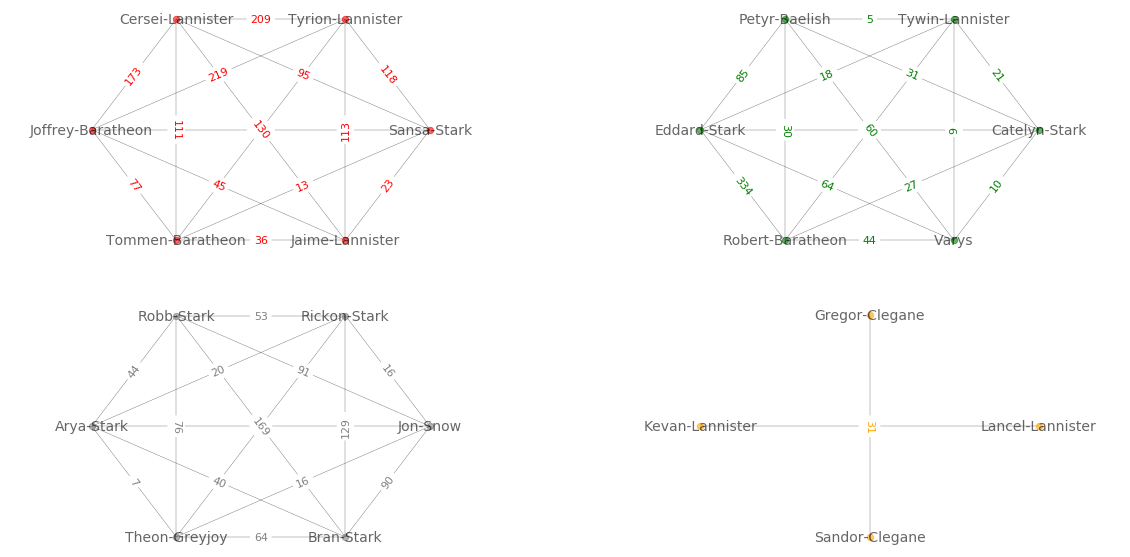

In [20]:
G_table1=G.subgraph(table1) 
G_table2=G.subgraph(table2)
G_table3=G.subgraph(table3)
G_table4=G.subgraph(table4)

subgraphs=[G_table1,G_table2,G_table3,G_table4]
colors=["red","green","gray","orange"]

plt.close()

fig = plt.figure(figsize=(20,10))    
# creating plot:
for table_num in range(4):
    col=colors[table_num]
    subgraph=subgraphs[table_num]
    # creating the subplot
    plt.subplot(2, 2, table_num+1)
    # defining node positions
    pos=nx.circular_layout(subgraph)
    # adding some extra margins so that labels can fit
    x_values, y_values = zip(*pos.values())
    x_max = max(x_values)
    x_min = min(x_values)
    x_margin = (x_max - x_min) * 0.25
    plt.xlim(x_min - x_margin, x_max + x_margin)
    # darwing the graph
    nx.draw(subgraph,node_size=40,width=0.4,with_labels=True,alpha=0.6,font_size=14,\
           pos=pos,node_color=col)
    # adding weights to edges
    nx.draw_networkx_edge_labels(subgraph,pos=pos,font_color=col,font_size=11,\
                                 edge_labels=nx.get_edge_attributes(subgraph,'weight'))
    
plt.savefig("zolp_wedding.png", bbox_inches='tight')
plt.show()




### 2 Spectral clustering<a class="anchor" id="method2"></a>


Another possible solution to create table arrangements can be done through clustering. We could use any clustering technique that is based on an adjacency- or distance matrix. An example of such method is spectral clustering. Clustering algorithms try to group observations so that the within group similarity or relatedness is maximized, so in essence they solve a similar optimization problem as our linear programming problem.  An important difference is that here, we cannot ensure that all clusters will be roughly the same size, and if one of the resulting group of guests is larger than the tables' seating capactiy, the seating arrangement won't be feasible. Depending on the wedding, this can be a small organization issue or a dealbreaker. For now, let's just try it to see if it produces similar results.

### 2.1 A toy example with spectral clustering <a class="anchor" id="example_2_1"></a>
First we apply spectral clustering to the same toy problem as in Section 1.1.

In [21]:
C_matrix=np.array([
[1,50,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
[50,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
[1,1,1,50,1,1,1,1,10,0,0,0,0,0,0,0,0],
[1,1,50,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
[1,1,1,1,1,50,1,1,1,0,0,0,0,0,0,0,0],
[1,1,1,1,50,1,1,1,1,0,0,0,0,0,0,0,0],
[1,1,1,1,1,1,1,50,1,0,0,0,0,0,0,0,0],
[1,1,1,1,1,1,50,1,1,0,0,0,0,0,0,0,0],
[1,1,10,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,1,50,1,1,1,1,1,1],
[0,0,0,0,0,0,0,0,0,50,1,1,1,1,1,1,1],
[0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
[0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
[0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
[0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
[0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
[0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1]])

# parameters
m = 17
n = 2
a = 10
b = 1
set_I = range(1, n+1)
set_J = range(1, m+1)
set_K = range(1, m+1)
C = {(j,k): C_matrix[(j-1),(k-1)] for j in set_J for k in set_K}

In [22]:
# running the clustering algorithm
clustering = spectral_clustering(n_clusters=2,
        assign_labels="discretize",
         random_state=0,affinity=C_matrix)

/Users/matevaradi/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [23]:
clustering

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

As we can see, the result is exactly the same as for the linear programming problem.

### 2.2 An imaginary Game of Thrones wedding with spectral clustering<a class="anchor" id="example_2_2"></a>

In [24]:
clustering = spectral_clustering(n_clusters=4,
        assign_labels="discretize",
         random_state=0,affinity=C_matrix_got)

In [25]:
table1=[characters[i] for i in range(len(characters)) if clustering[i]==0]
table2=[characters[i] for i in range(len(characters)) if clustering[i]==1]
table3=[characters[i] for i in range(len(characters)) if clustering[i]==2]
table4=[characters[i] for i in range(len(characters)) if clustering[i]==3]

# displaying results
print("Table 1:",table1)
print("Table 2:",table2)
print("Table 3:",table3)
print("Table 4:",table4)

Table 1: ['Arya-Stark', 'Sansa-Stark', 'Joffrey-Baratheon', 'Gregor-Clegane', 'Sandor-Clegane']
Table 2: ['Jon-Snow', 'Bran-Stark', 'Rickon-Stark', 'Theon-Greyjoy', 'Robb-Stark']
Table 3: ['Catelyn-Stark', 'Eddard-Stark', 'Robert-Baratheon', 'Varys', 'Petyr-Baelish']
Table 4: ['Tyrion-Lannister', 'Jaime-Lannister', 'Cersei-Lannister', 'Lancel-Lannister', 'Tywin-Lannister', 'Kevan-Lannister', 'Tommen-Baratheon']


It appears that the clustering algorithm wants to seperate husband and wife in this case. In a real life application of course, we would not include them in the seating arrangement optimization, as they already have their seats. In the model, if we want to avoid or enforce certain pairs of guests sitting together we can simply increase of decrease their relatedness in the connection matrix. 

We can of course run the same visualization as with the results of the zero-one lp method:

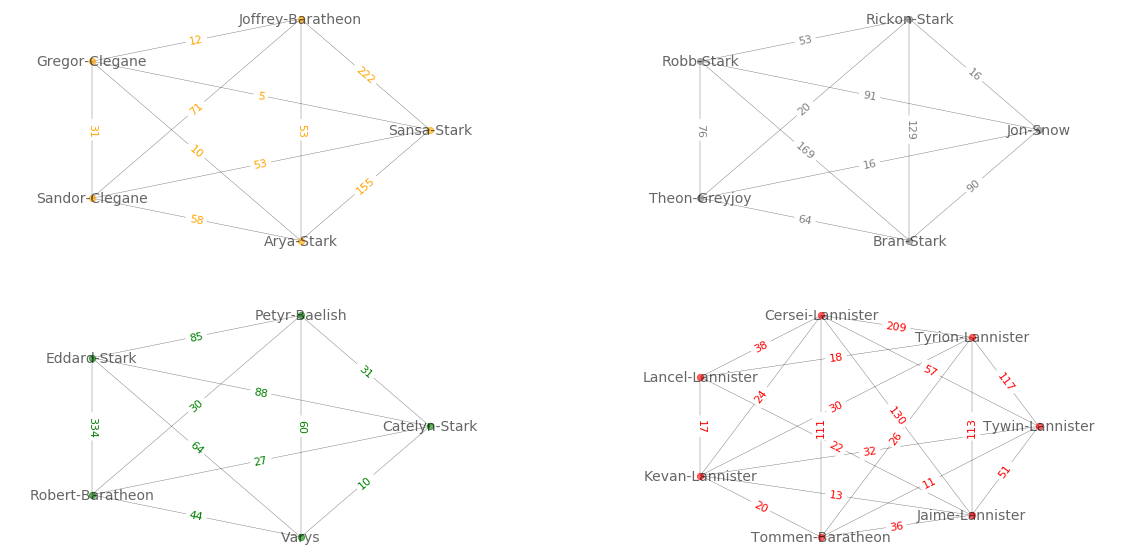

In [26]:
G_table1=G.subgraph(table1) 
G_table2=G.subgraph(table2)
G_table3=G.subgraph(table3)
G_table4=G.subgraph(table4)

subgraphs=[G_table1,G_table2,G_table3,G_table4]
colors=["orange","gray","green","red"]

plt.close()

fig = plt.figure(figsize=(20,10))    
# creating plot:
for table_num in range(4):
    col=colors[table_num]
    subgraph=subgraphs[table_num]
    # creating the subplot
    plt.subplot(2, 2, table_num+1)
    # defining node positions
    pos=nx.circular_layout(subgraph)
    # adding some extra margins so that labels can fit
    x_values, y_values = zip(*pos.values())
    x_max = max(x_values)
    x_min = min(x_values)
    x_margin = (x_max - x_min) * 0.25
    plt.xlim(x_min - x_margin, x_max + x_margin)
    # darwing the graph
    nx.draw(subgraph,node_size=40,width=0.4,with_labels=True,alpha=0.6,font_size=14,\
           pos=pos,node_color=col)
    # adding weights to edges
    nx.draw_networkx_edge_labels(subgraph,pos=pos,font_color=col,font_size=11,\
                                 edge_labels=nx.get_edge_attributes(subgraph,'weight'))
    
plt.savefig("spectralclust_wedding.png", bbox_inches='tight')
plt.show()




### 3 Summary<a class="anchor" id="summary"></a>
We saw that both zero-one linear programming and clustering techniques, such as spectral clustering can solve the problem of optimal seating at a wedding. Spectral clustering is faster, but it is not guaranteed that the resulting groups can actually sit down the way the algorithm intends them to, as constraints such as the seating capacity of tables are not input to the algorithm. Of course many different clustering techniques exist, and extensions to them can be derived so it is possible that there is a clustering algorithm out there that could be perfect for this task. Zero-one linear programming works very well and it can be tailor-made to our exact needs, but when we have many guests, computation can take quite some time. 


## References:
* [[1]](https://www.improbable.com/news/2012/Optimal-seating-chart.pdf) Bellows, M., & Peterson, J. L. (2012). Finding an optimal seating chart. Annals of Improbable Research, 2.
* [[2]](https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf) Ng, A. Y., Jordan, M. I., & Weiss, Y. (2002). On spectral clustering: Analysis and an algorithm. In Advances in neural information processing systems (pp. 849-856).
* [[3]](https://medium.com/opex-analytics/optimization-modeling-in-python-pulp-gurobi-and-cplex-83a62129807a) Optimization Modeling in Python: Pulp, Gurobi, and CPLEX - Medium